In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.165:33067,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
print(client)

<Client: 'tcp://10.0.128.165:33067' processes=0 threads=0, memory=0 B>


In [5]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [6]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [7]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [8]:
Grid

xgcm.grid.Grid

In [9]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")


def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(150,160))
    gl.ylocator = mticker.FixedLocator(np.arange(-45,45))

    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.set_title('')
    return ax

In [10]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [11]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def makeROMSGridObject(ds,rename=True):
    if rename==True:
        ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds, grid

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    # metrics={
    #     ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    #     ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    #     ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    #     ('X', 'Y'): ['dA'] # Areas
    # },
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [12]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

def calc_depthAverageROMS2(input,dx,dz0,etaTransect):
    input = input.isel(eta_rho=etaTransect)
    dz = dz0.isel(eta_rho=etaTransect)
    dx = dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [13]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [14]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))

# time_range_to_load_S = slice('2012-01-01','2012-06-01')
# time_range_to_load_N = slice('2012-06-01','2012-11-01')

time_range_to_load_S = slice('2012-04-20','2012-04-21')
time_range_to_load_N = slice('2012-03-06','2012-03-07')
time_range_to_load_eddyN = slice('2012-06-29','2012-07-09')
time_range_to_load_eddy1 = slice('2012-03-06','2012-03-12')
time_range_to_load_eddy2 = slice('2012-07-29','2012-08-08')
time_range_to_load_eddy3 = slice('2012-03-11','2012-03-16')


range_S = (str(time_range_to_load_S.start)+' - '+str(time_range_to_load_S.stop))
range_N = (str(time_range_to_load_N.start)+' - '+str(time_range_to_load_N.stop))
range_eddyN = (str(time_range_to_load_eddyN.start)+' - '+str(time_range_to_load_eddyN.stop))
range_eddy1 = (str(time_range_to_load_eddy1.start)+' - '+str(time_range_to_load_eddy1.stop))
range_eddy2 = (str(time_range_to_load_eddy2.start)+' - '+str(time_range_to_load_eddy2.stop))
range_eddy3 = (str(time_range_to_load_eddy3.start)+' - '+str(time_range_to_load_eddy3.stop))

In [15]:
# Load zeta data
VarToKeep = ['z_rho0','temp','dz_w']#,'dA','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix
print('load truth')
truth = xr.open_dataset(filelistTruth)

truth = truth.sel(ocean_time=slice('2012-01-01','2012-12-31'))


truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
truth = truth.drop_vars('z_rho')
truth["dz0"] = truth_bu.dz.mean(dim='ocean_time')
truth["dz_w0"]=truth_bu.dz_w.mean(dim='ocean_time')
truth["dx"] = truth_bu.dx
truth["z_rho0"] = truth.z_rho0.fillna(0)
truth["z_w0"]=truth_bu.z_w.mean(dim='ocean_time').fillna(0)
truth["s_w"] = truth_bu.s_w
truth["s_w3"],dump = xr.broadcast(truth.s_w,truth.lon_rho)

print('load OSSEs')

OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)

OSSE_SSHSST = OSSE_SSHSST.sel(ocean_time=slice('2012-01-01','2012-12-31'))
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.sel(ocean_time=slice('2012-01-01','2012-12-31'))
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.sel(ocean_time=slice('2012-01-01','2012-12-31'))
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.sel(ocean_time=slice('2012-01-01','2012-12-31'))



print('make grid file')

#load grid file
grid = makeROMSGridObject(OSSE_SSHSST)

print('trim vars')
OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)
OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)

print('make dz vars 1')

OSSE_SSHSST = OSSE_SSHSST.drop_vars('z_rho')
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop_vars('z_rho')
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop_vars('z_rho')
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop_vars('z_rho')
print('make dz vars 2')

OSSE_SSHSST["z_rho0"] = OSSE_SSHSST.z_rho0.fillna(0)
OSSE_SSHSST_XBT["z_rho0"] = OSSE_SSHSST_XBT.z_rho0.fillna(0)
OSSE_SSHSST_XBT_N["z_rho0"] = OSSE_SSHSST_XBT_N.z_rho0.fillna(0)
OSSE_SSHSST_XBT_S["z_rho0"] = OSSE_SSHSST_XBT_S.z_rho0.fillna(0)
print('make dz vars 3')

OSSE_SSHSST["z_w0"]=OSSE_SSHSST_bu.z_w.mean(dim='ocean_time').fillna(0)
OSSE_SSHSST_XBT["z_w0"]=OSSE_SSHSST_XBT_bu.z_w.mean(dim='ocean_time').fillna(0)
OSSE_SSHSST_XBT_N["z_w0"]=OSSE_SSHSST_XBT_N_bu.z_w.mean(dim='ocean_time').fillna(0)
OSSE_SSHSST_XBT_S["z_w0"]=OSSE_SSHSST_XBT_S_bu.z_w.mean(dim='ocean_time').fillna(0)

# print('make dz vars 4')
# OSSE_SSHSST["dz0"] = OSSE_SSHSST_bu.dz.mean(dim='ocean_time')
# OSSE_SSHSST_XBT["dz0"] = OSSE_SSHSST_XBT_bu.dz.mean(dim='ocean_time')
# OSSE_SSHSST_XBT_N["dz0"] = OSSE_SSHSST_XBT_N_bu.dz.mean(dim='ocean_time')
# OSSE_SSHSST_XBT_S["dz0"] = OSSE_SSHSST_XBT_S_bu.dz.mean(dim='ocean_time')

print('make dz vars 5')
OSSE_SSHSST["dz_w0"]=OSSE_SSHSST.dz_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT["dz_w0"]=OSSE_SSHSST_XBT.dz_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT_N["dz_w0"]=OSSE_SSHSST_XBT_N_bu.dz_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT_S["dz_w0"]=OSSE_SSHSST_XBT_S_bu.dz_w.mean(dim='ocean_time')

print('make dx vars')
OSSE_SSHSST["dx"] = OSSE_SSHSST_bu.dx
OSSE_SSHSST_XBT["dx"] = OSSE_SSHSST_XBT_bu.dx
OSSE_SSHSST_XBT_N["dx"] = OSSE_SSHSST_XBT_N_bu.dx
OSSE_SSHSST_XBT_S["dx"] = OSSE_SSHSST_XBT_S_bu.dx

print('make s_w vars')

OSSE_SSHSST["s_w"] = OSSE_SSHSST_bu.s_w
OSSE_SSHSST["s_w3"],dump = xr.broadcast(OSSE_SSHSST.s_w,OSSE_SSHSST.lon_rho)
OSSE_SSHSST_XBT["s_w"] = OSSE_SSHSST_XBT_bu.s_w
OSSE_SSHSST_XBT["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT.s_w,OSSE_SSHSST_XBT.lon_rho)
OSSE_SSHSST_XBT_N["s_w"] = OSSE_SSHSST_XBT_N_bu.s_w
OSSE_SSHSST_XBT_N["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT_N.s_w,OSSE_SSHSST_XBT_N.lon_rho)
OSSE_SSHSST_XBT_S["s_w"] = OSSE_SSHSST_XBT_S_bu.s_w
OSSE_SSHSST_XBT_S["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT_S.s_w,OSSE_SSHSST_XBT_S.lon_rho)

print('drop extraneous vars')
truth = truth.drop_vars(['z_w','dz_w'])
OSSE_SSHSST = OSSE_SSHSST.drop_vars(['z_w','dz_w'])
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop_vars(['z_w','dz_w'])
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop_vars(['z_w','dz_w'])
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop_vars(['z_w','dz_w'])

SSHSST = OSSE_SSHSST
SSHSST_XBT_N = OSSE_SSHSST_XBT_N
SSHSST_XBT_S = OSSE_SSHSST_XBT_S
SSHSST_XBT = OSSE_SSHSST_XBT

print('load datasets')


truth.load(), print('done, loaded ~'+str(truth.nbytes/1024/1024/1024)+'G')
SSHSST.load(), print('done, loaded ~'+str(SSHSST.nbytes/1024/1024/1024)+'G')
SSHSST_XBT.load(), print('done, loaded ~'+str(SSHSST_XBT.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N.load(), print('done, loaded ~'+str(SSHSST_XBT_N.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S.load(), print('done, loaded ~'+str(SSHSST_XBT_S.nbytes/1024/1024/1024)+'G')


load truth
load OSSEs
make grid file
trim vars
make dz vars 1
make dz vars 2
make dz vars 3
make dz vars 5
make dx vars
make s_w vars
drop extraneous vars
load datasets
done, loaded ~1.5263882204890251G
done, loaded ~1.5071156546473503G
done, loaded ~1.5071156546473503G
done, loaded ~1.5071156546473503G
done, loaded ~1.5071156546473503G


(<xarray.Dataset>
 Dimensions:     (eta_rho: 317, xi_rho: 272, s_rho: 30, ocean_time: 74, s_w: 31)
 Coordinates:
     z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.485 -1.037
   * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
   * s_w         (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
     lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time  (ocean_time) datetime64[ns] 2012-01-01 2012-01-06 ... 2012-12-31
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.61
     z_w0        (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.4931 0.4931
     dz_w0       (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 1.029 1.029 1.029
     dx          (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
     s_w3        (s_w, eta_r

In [16]:
SSHSST

<xarray.Dataset>
Dimensions:     (eta_rho: 317, xi_rho: 272, s_rho: 30, ocean_time: 74, s_w: 31)
Coordinates:
    z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.492 -1.044
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w         (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
  * ocean_time  (ocean_time) datetime64[ns] 2012-01-01 2012-01-06 ... 2012-12-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.75
    z_w0        (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.4869 0.4869
    dz_w0       (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 1.036 1.035 1.035
    dx          (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
    s_w3        (s_w, eta_rho, xi_rho) float64 -1.0 -1.0 -1.0 ... 0.0 0.0 0.0
Attributes: (12/39)
    file:              roms_fwd_outer1.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.1.0/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Wednesday - September 1, 2021 ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADJOINT, ADJUST_BOUNDARY, ADJUST_STFLUX, ADJUST_W...

In [17]:
# calculate the sharpest change in temp with depth (for each experiment)
## first calculate the grid coordinate where diff is maximised, then extract the z_w value where this occurs and only keep the top value
truth["z_dtdzmax"] = truth.z_w0.where(truth.s_w3==(grid.diff(truth.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/truth.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
SSHSST["z_dtdzmax"] = SSHSST.z_w0.where(SSHSST.s_w3==(grid.diff(SSHSST.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
SSHSST_XBT["z_dtdzmax"] = SSHSST_XBT.z_w0.where(SSHSST_XBT.s_w3==(grid.diff(SSHSST_XBT.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
SSHSST_XBT_N["z_dtdzmax"] = SSHSST_XBT_N.z_w0.where(SSHSST_XBT_N.s_w3==(grid.diff(SSHSST_XBT_N.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT_N.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
SSHSST_XBT_S["z_dtdzmax"] = SSHSST_XBT_S.z_w0.where(SSHSST_XBT_S.s_w3==(grid.diff(SSHSST_XBT_S.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT_S.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')


In [18]:
import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.Stamen('terrain-background')

Text(0.5, 0.86, 'Thermocline depth (max dT/dz)')

<Figure size 432x288 with 0 Axes>

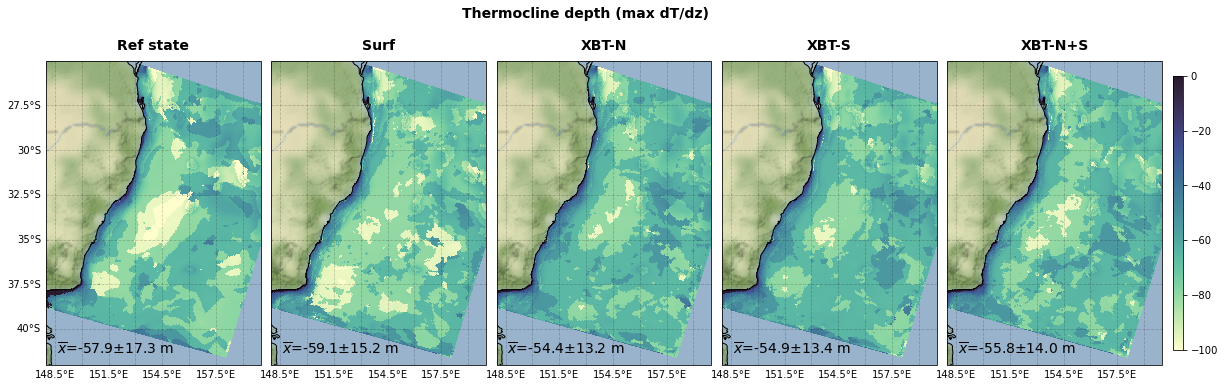

In [19]:


gs = gridspec.GridSpec(nrows=1,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
truth.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
SSHSST.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
SSHSST_XBT_N.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
SSHSST_XBT_S.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
im=SSHSST_XBT.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 

fig.suptitle('Thermocline depth (max dT/dz)',y=.86, fontsize=14, fontweight='bold',)

In [20]:
def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output


In [21]:
str(calc_areaAverageROMS(SSHSST_XBT.z_dtdzmax,truth_bu).round(decimals=1).values)

'-55.8'

In [22]:
SSHSST.z_rho0.shape

(317, 272, 30)

In [23]:
SSHSST.temp.load()
SSHSST.z_rho0.load()

<xarray.DataArray 'z_rho0' (eta_rho: 317, xi_rho: 272, s_rho: 30)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-4.41276142e+03, -4.14478789e+03, -3.65333890e+03, ...,
         -1.05665760e+01, -5.76686282e+00, -1.70172370e+00],
        [-4.44297790e+03, -4.17316152e+03, -3.67821177e+03, ...,
         -1.05740580e+01, -5.77001255e+00, -1.70193446e+00],
        [-4.44297790e+03, -4.17316152e+03, -3.67821177e+03, ...,
         -1.05740581e+01, -5.77001257e+00, -1.70193448e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
        [-1.48925895e+03, -1.39944903e+03, -1.24483565e+03, ...,
         -8.49135229e+00, -4.49255802e+00, -1.04488603e+00],
        [-1.48979603e+03, -1.39995335e+03, -1.24527880e+03, ...,
         -8.49080885e+00, -4.49168568e+00, -1.04374169e+00],
        [-1.48979603e+03, -1.39995335e+03, -1.24527880e+03, ...,
         -8.49080705e+00, -4.49168387e+00, -1.04373988e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.48925895e+03, -1.39944903e+03, -1.24483565e+03, ...,
         -8.49135100e+00, -4.49255672e+00, -1.04488473e+00],
        [-1.48979603e+03, -1.39995335e+03, -1.24527880e+03, ...,
         -8.49080724e+00, -4.49168406e+00, -1.04374007e+00],
        [-1.48979603e+03, -1.39995335e+03, -1.24527880e+03, ...,
         -8.49080714e+00, -4.49168396e+00, -1.04373997e+00]]])
Coordinates:
    z_rho0   (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.492 -1.044
  * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
    lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
Dimensions without coordinates: eta_rho, xi_rho

In [24]:
SSHSST

<xarray.Dataset>
Dimensions:     (eta_rho: 317, xi_rho: 272, s_rho: 30, ocean_time: 74, s_w: 31)
Coordinates:
    z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.492 -1.044
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w         (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
  * ocean_time  (ocean_time) datetime64[ns] 2012-01-01 2012-01-06 ... 2012-12-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.75
    z_w0        (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.4869 0.4869
    dz_w0       (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 1.036 1.035 1.035
    dx          (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
    s_w3        (s_w, eta_rho, xi_rho) float64 -1.0 -1.0 -1.0 ... 0.0 0.0 0.0
    z_dtdzmax   (eta_rho, xi_rho) float64 nan nan nan ... -49.5 -41.29 -41.29
Attributes: (12/39)
    file:              roms_fwd_outer1.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.1.0/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Wednesday - September 1, 2021 ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADJOINT, ADJUST_BOUNDARY, ADJUST_STFLUX, ADJUST_W...

In [25]:
# print(SSHSST.isel(eta_rho=125,xi_rho=140).depthMLD)
# print(SSHSST.z_dtdzmax.isel(eta_rho=125,xi_rho=140))

In [26]:
# print(SSHSST.temp.mean(dim=['ocean_time','xi_rho','eta_rho']).isel(s_rho=26))
# print(SSHSST.z_rho0.mean(dim=['xi_rho','eta_rho']).isel(s_rho=26))

In [27]:

# # %matplotlib inline

# plt.figure(figsize=[10,10])
# plt.plot(SSHSST.temp.mean(dim=['ocean_time','xi_rho','eta_rho']),SSHSST.z_rho0.mean(dim=['xi_rho','eta_rho']))
# plt.plot([10,22],[SSHSST.depthMLD.mean(dim=['xi_rho','eta_rho']),SSHSST.depthMLD.mean(dim=['xi_rho','eta_rho'])])
# plt.plot([10,22],[SSHSST.z_dtdzmax.mean(dim=['xi_rho','eta_rho']),SSHSST.z_dtdzmax.mean(dim=['xi_rho','eta_rho'])])
# plt.ylim(-60,0)
# plt.xlim(17.5,21.5)
# plt.grid()

# plt.figure(figsize=[10,10])
# plt.plot(SSHSST.temp.mean(dim=['ocean_time']).isel(eta_rho=125,xi_rho=140),SSHSST.z_rho0.isel(eta_rho=125,xi_rho=140))
# plt.plot([10,22],[SSHSST.depthMLD.mean(dim=['xi_rho','eta_rho']),SSHSST.depthMLD.mean(dim=['xi_rho','eta_rho'])])
# plt.plot([10,22],[SSHSST.z_dtdzmax.isel(eta_rho=125,xi_rho=140),SSHSST.z_dtdzmax.isel(eta_rho=125,xi_rho=140)])
# plt.plot(500*grid.diff(SSHSST.temp.mean(dim='ocean_time').isel(eta_rho=125,xi_rho=140),'Z',boundary='fill',fill_value=np.nan)/SSHSST.dz_w0.isel(eta_rho=125,xi_rho=140),SSHSST.z_w0.isel(eta_rho=125,xi_rho=140))
# plt.plot([10,22],[SSHSST.isel(eta_rho=125,xi_rho=140).depthMLD-2*(SSHSST.isel(eta_rho=125,xi_rho=140).depthMLD-SSHSST.z_dtdzmax.isel(eta_rho=125,xi_rho=140)),SSHSST.isel(eta_rho=125,xi_rho=140).depthMLD-2*(SSHSST.isel(eta_rho=125,xi_rho=140).depthMLD-SSHSST.z_dtdzmax.isel(eta_rho=125,xi_rho=140))])

# plt.ylim(-3000,0)



In [28]:

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics={
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    return gridOut


grid = makeROMSGridObject(OSSE_SSHSST_bu)


In [29]:
SSHSST["dTdz"]=grid.derivative(SSHSST.temp,'Z',boundary='fill',fill_value=np.nan)

In [30]:
# test = grid.derivative(SSHSST.dTdz,'Z',boundary='fill',fill_value=np.nan)

In [31]:
SSHSST.dTdz.mean(dim='ocean_time')

<xarray.DataArray 'dTdz' (s_w: 31, eta_rho: 317, xi_rho: 272)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
         1.71212057e-04, 1.53828532e-04, 1.47980484e-04],
        [           nan,            nan,            nan, ...,
         3.08034514e-05, 3.25468258e-05, 1.42132436e-04],
        [           nan,            nan,            nan, ...,
         2.48258683e-05, 2.72204659e-05, 1.41590310e-04],
...
        [           nan,            nan,            nan, ...,
         8.62913728e-03, 9.43790696e-03, 1.09590769e-02],
        [           nan,            nan,            nan, ...,
         1.05826422e-02, 1.15801271e-02, 1.19267091e-02],
        [           nan,            nan,            nan, ...,
         1.11508671e-02, 1.09666618e-02, 1.14466855e-02]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * s_w      (s_w) float64 -1.0 -0.9433 -0.8883 -0.8348 ... -0.02161 -0.01 0.0
    lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
    lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
Dimensions without coordinates: eta_rho, xi_rho

(-3000.0, 0.0)

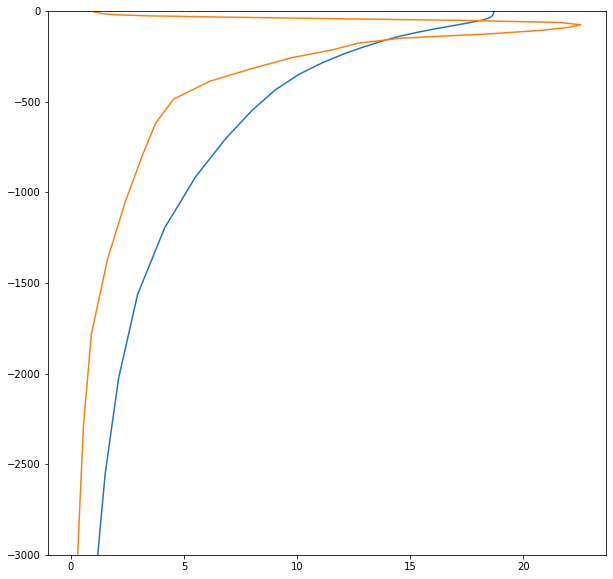

In [32]:
plt.figure(figsize=[10,10])
plt.plot(SSHSST.temp.mean(dim=['ocean_time']).isel(eta_rho=100,xi_rho=220),SSHSST.z_rho0.isel(eta_rho=100,xi_rho=220))
# plt.plot([10,22],[SSHSST.dTdz.mean(dim=['ocean_time']).isel(eta_rho=125,xi_rho=140),SSHSST.dTdz.mean(dim=['ocean_time']).isel(eta_rho=125,xi_rho=140)])
plt.plot(500*SSHSST.dTdz.mean(dim=['ocean_time']).isel(eta_rho=100,xi_rho=220),SSHSST.z_w0.isel(eta_rho=100,xi_rho=220))
plt.ylim(-3000,0)

In [33]:
depth_DeepWater = -400 # deep water temperature 
temp_offsetMLD = 0.5 # 0.5 is Monteray and Levitus 1997; 0.8 is Kara et al., 2000,2003
fielder_variable = 0.25

truth["tempDW"] = horizontalSectionROMS(grid, truth.temp, np.array([depth_DeepWater]))
SSHSST["tempDW"] = horizontalSectionROMS(grid, SSHSST.temp, np.array([depth_DeepWater]))
SSHSST_XBT_N["tempDW"] = horizontalSectionROMS(grid, SSHSST_XBT_N.temp, np.array([depth_DeepWater]))
SSHSST_XBT_S["tempDW"] = horizontalSectionROMS(grid, SSHSST_XBT_S.temp, np.array([depth_DeepWater]))
SSHSST_XBT["tempDW"] = horizontalSectionROMS(grid, SSHSST_XBT.temp, np.array([depth_DeepWater]))

truth["temp0"] = truth.temp.isel(s_rho=-1)
SSHSST["temp0"] = SSHSST.temp.isel(s_rho=-1)
SSHSST_XBT_N["temp0"] = SSHSST_XBT_N.temp.isel(s_rho=-1)
SSHSST_XBT_S["temp0"] = SSHSST_XBT_S.temp.isel(s_rho=-1)
SSHSST_XBT["temp0"] = SSHSST_XBT.temp.isel(s_rho=-1)



truth["tempMLD"] = truth.temp0 - temp_offsetMLD
truth["tempTC"] = truth.tempMLD - fielder_variable*(truth.tempMLD-truth.tempDW)

SSHSST["tempMLD"] = SSHSST.temp0 - temp_offsetMLD
SSHSST["tempTC"] = SSHSST.tempMLD - fielder_variable*(SSHSST.tempMLD-SSHSST.tempDW)

SSHSST_XBT_N["tempMLD"] = SSHSST_XBT_N.temp0 - temp_offsetMLD
SSHSST_XBT_N["tempTC"] = SSHSST_XBT_N.tempMLD - fielder_variable*(SSHSST_XBT_N.tempMLD-SSHSST_XBT_N.tempDW)

SSHSST_XBT_S["tempMLD"] = SSHSST_XBT_S.temp0 - temp_offsetMLD
SSHSST_XBT_S["tempTC"] = SSHSST_XBT_S.tempMLD - fielder_variable*(SSHSST_XBT_S.tempMLD-SSHSST_XBT_S.tempDW)

SSHSST_XBT["tempMLD"] = SSHSST_XBT.temp0 - temp_offsetMLD
SSHSST_XBT["tempTC"] = SSHSST_XBT.tempMLD - fielder_variable*(SSHSST_XBT.tempMLD-SSHSST_XBT.tempDW)


In [34]:
truth.temp.mean(dim='ocean_time').isel(xi_rho=140,eta_rho=125)

<xarray.DataArray 'temp' (s_rho: 30)>
array([ 0.9376638 ,  0.93999605,  0.96272916,  1.16631802,  1.65997974,
        2.50827267,  3.74009055,  5.29001387,  7.0663595 ,  9.00447196,
       10.94505495, 12.73078877, 14.31788902, 15.55348329, 16.47478904,
       17.21581517, 17.84826135, 18.46605034, 19.12433676, 19.80262663,
       20.35111205, 20.70839064, 20.93299571, 21.09719875, 21.23065205,
       21.31818584, 21.36461504, 21.38673269, 21.39987358, 21.41765484])
Coordinates:
    z_rho0   (s_rho) float64 -4.802e+03 -4.51e+03 -3.974e+03 ... -5.422 -1.321
  * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho  float64 153.2
    lat_rho  float64 -34.34

In [35]:
truth.eta_rho

<xarray.DataArray 'eta_rho' (eta_rho: 317)>
array([  0,   1,   2, ..., 314, 315, 316])
Dimensions without coordinates: eta_rho

In [36]:
test = np.empty([*truth.tempMLD.mean(dim='ocean_time').shape])
test.fill(np.nan)
test.shape

(317, 272)

In [37]:
# from scipy import interpolate
# ii = interpolate.interp1d(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])**2,np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
# ii(20)

In [38]:
# # Testing of this interpolation scheme

from scipy import interpolate
def calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims):
    # outfield = np.empty([*queryfield.shape])
    # outfield.fill(np.nan)
    outfield = queryfield*np.nan
    for xx in xxlims:
        for ee in eelims:
            ii = interpolate.interp1d(tempfield.isel(xi_rho=xx,eta_rho=ee),depthfield.isel(xi_rho=xx,eta_rho=ee),bounds_error=False,fill_value=np.nan)
            outfield[ee,xx] = ii(queryfield.isel(xi_rho=xx,eta_rho=ee))
        if xx.values in np.round(np.linspace(0,len(xxlims.values),10)):
            print(xx.values)
    return outfield


# depthTC = (truth.tempTC.mean(dim='ocean_time')*np.nan).load()
# tempfield = truth.temp.mean(dim='ocean_time').load()
# depthfield = truth.z_rho0.load()
# queryfield = truth.tempTC.mean(dim='ocean_time').load()
# xxlims = truth.xi_rho.load()
# eelims = truth.eta_rho.load()

# depthTC = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)



In [39]:
# interpolate for find depths of thermocline

xxlims = truth.xi_rho.load()
eelims = truth.eta_rho.load()

#truth
tempfield = truth.temp.mean(dim='ocean_time').load()
depthfield = truth.z_rho0.load()
queryfield = truth.tempMLD.mean(dim='ocean_time').load()

truth["depthMLD"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

#SSHSST
tempfield = SSHSST.temp.mean(dim='ocean_time').load()
depthfield = SSHSST.z_rho0.load()
queryfield = SSHSST.tempMLD.mean(dim='ocean_time').load()

SSHSST["depthMLD"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

#SSHSST_XBT_N
tempfield = SSHSST_XBT_N.temp.mean(dim='ocean_time').load()
depthfield = SSHSST_XBT_N.z_rho0.load()
queryfield = SSHSST_XBT_N.tempMLD.mean(dim='ocean_time').load()

SSHSST_XBT_N["depthMLD"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

#SSHSST_XBT_S
tempfield = SSHSST_XBT_S.temp.mean(dim='ocean_time').load()
depthfield = SSHSST_XBT_S.z_rho0.load()
queryfield = SSHSST_XBT_S.tempMLD.mean(dim='ocean_time').load()

SSHSST_XBT_S["depthMLD"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

#SSHSST_XBT
tempfield = SSHSST_XBT.temp.mean(dim='ocean_time').load()
depthfield = SSHSST_XBT.z_rho0.load()
queryfield = SSHSST_XBT.tempMLD.mean(dim='ocean_time').load()

SSHSST_XBT["depthMLD"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242


In [40]:
# interpolate for find depths of thermocline

xxlims = truth.xi_rho.load()
eelims = truth.eta_rho.load()

#truth
tempfield = truth.temp.mean(dim='ocean_time').load()
depthfield = truth.z_rho0.load()
queryfield = truth.tempTC.mean(dim='ocean_time').load()

truth["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

#SSHSST
tempfield = SSHSST.temp.mean(dim='ocean_time').load()
depthfield = SSHSST.z_rho0.load()
queryfield = SSHSST.tempTC.mean(dim='ocean_time').load()

SSHSST["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

#SSHSST_XBT_N
tempfield = SSHSST_XBT_N.temp.mean(dim='ocean_time').load()
depthfield = SSHSST_XBT_N.z_rho0.load()
queryfield = SSHSST_XBT_N.tempTC.mean(dim='ocean_time').load()

SSHSST_XBT_N["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

#SSHSST_XBT_S
tempfield = SSHSST_XBT_S.temp.mean(dim='ocean_time').load()
depthfield = SSHSST_XBT_S.z_rho0.load()
queryfield = SSHSST_XBT_S.tempTC.mean(dim='ocean_time').load()

SSHSST_XBT_S["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

#SSHSST_XBT
tempfield = SSHSST_XBT.temp.mean(dim='ocean_time').load()
depthfield = SSHSST_XBT.z_rho0.load()
queryfield = SSHSST_XBT.tempTC.mean(dim='ocean_time').load()

SSHSST_XBT["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)





truth["depthTCmaxdTdz"] = truth.depthMLD - 2*(truth.depthMLD-truth.z_dtdzmax)
SSHSST["depthTCmaxdTdz"] = SSHSST.depthMLD - 2*(SSHSST.depthMLD-SSHSST.z_dtdzmax)
SSHSST_XBT_N["depthTCmaxdTdz"] = SSHSST_XBT_N.depthMLD - 2*(SSHSST_XBT_N.depthMLD-SSHSST_XBT_N.z_dtdzmax)
SSHSST_XBT_S["depthTCmaxdTdz"] = SSHSST_XBT_S.depthMLD - 2*(SSHSST_XBT_S.depthMLD-SSHSST_XBT_S.z_dtdzmax)
SSHSST_XBT["depthTCmaxdTdz"] = SSHSST_XBT.depthMLD - 2*(SSHSST_XBT.depthMLD-SSHSST_XBT.z_dtdzmax)

0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242


Text(0.5, 0.86, 'Thermocline depth ( z(T(MLD)-0.25(T(MLD)-T(400m)), T(MLD)=SST-0.8)')

<Figure size 432x288 with 0 Axes>

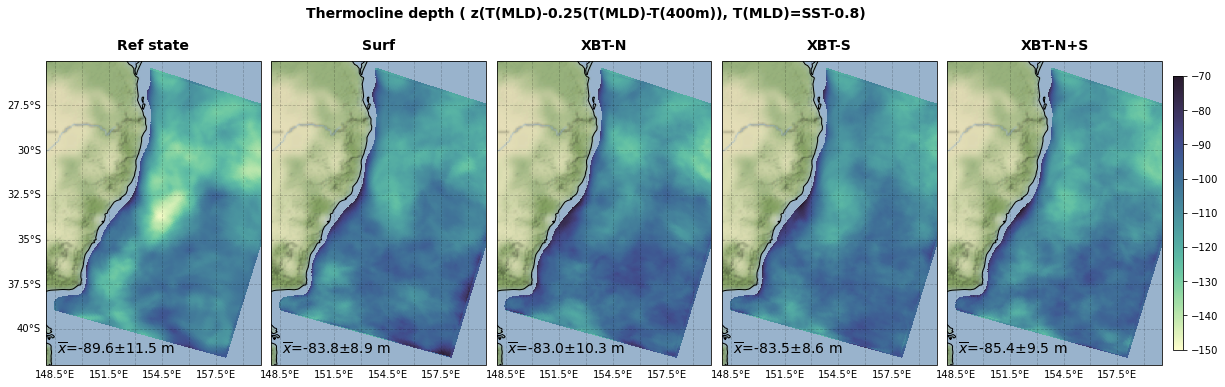

In [41]:


gs = gridspec.GridSpec(nrows=1,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
truth.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
SSHSST.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
SSHSST_XBT_N.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
SSHSST_XBT_S.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
im=SSHSST_XBT.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 

fig.suptitle('Thermocline depth ( z(T(MLD)-0.25(T(MLD)-T(400m)), T(MLD)=SST-0.8)',y=.86, fontsize=14, fontweight='bold')
# fig.suptitle('                  (z(T(MLD)-0.25(T(MLD)-T(400m))))',y=.83, fontsize=14, fontweight='bold',)

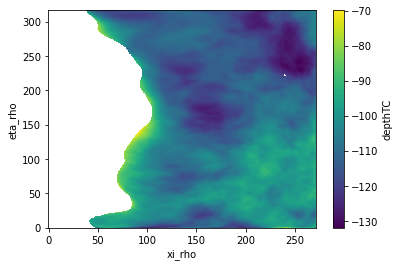

In [42]:
SSHSST_XBT.depthTC.plot()

In [43]:
# SSHSST_XBT.temp.mean(dim='ocean_time').isel(xi_rho=140,eta_rho=125).plot(y='z_rho0',marker='o')
# print(SSHSST_XBT.tempMLD.mean(dim='ocean_time').isel(xi_rho=140,eta_rho=125))
# plt.ylim(-400,0)

<Figure size 432x288 with 0 Axes>

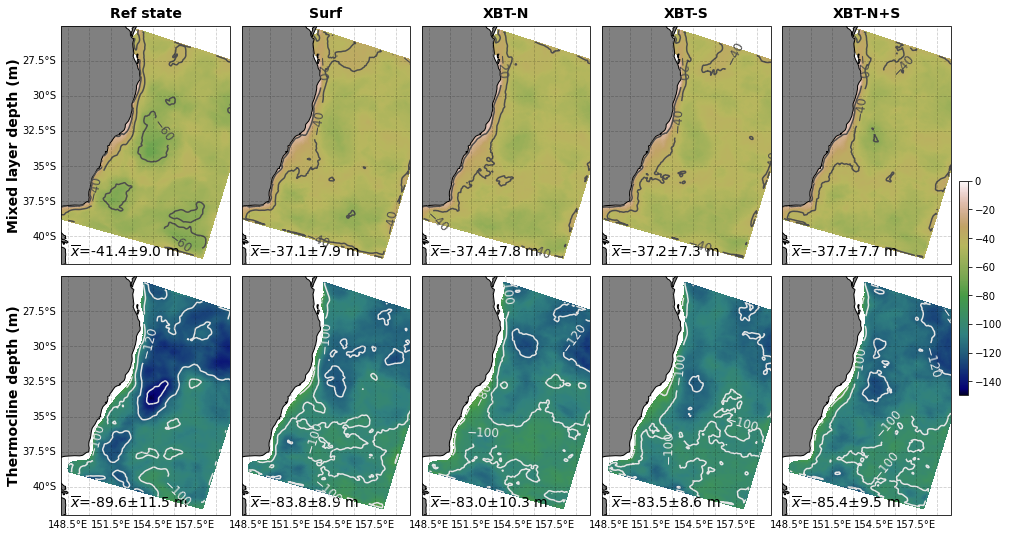

In [44]:


gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,9])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
truth.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Mixed layer depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="90%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(1.05,.05, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 



ax = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
truth.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Thermocline depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-150,vmax=-0)
co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.5, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 


# fig.suptitle('Thermocline depth ( z(T(MLD)-0.25(T(MLD)-T(400m)), T(MLD)=SST-0.8)',y=.96, fontsize=14, fontweight='bold')
# fig.suptitle('                  (z(T(MLD)-0.25(T(MLD)-T(400m))))',y=.83, fontsize=14, fontweight='bold',)

In [45]:
# Brief interlude to test the various area averaging functions
weights = truth_bu.dA
weights.name = "weights"
# xarray based area averaging
# test = truth.temp.isel(s_rho=-1).weighted(weights).mean(("eta_rho","xi_rho"))
# test.mean(("eta_rho","xi_rho"))

<Figure size 432x288 with 0 Axes>

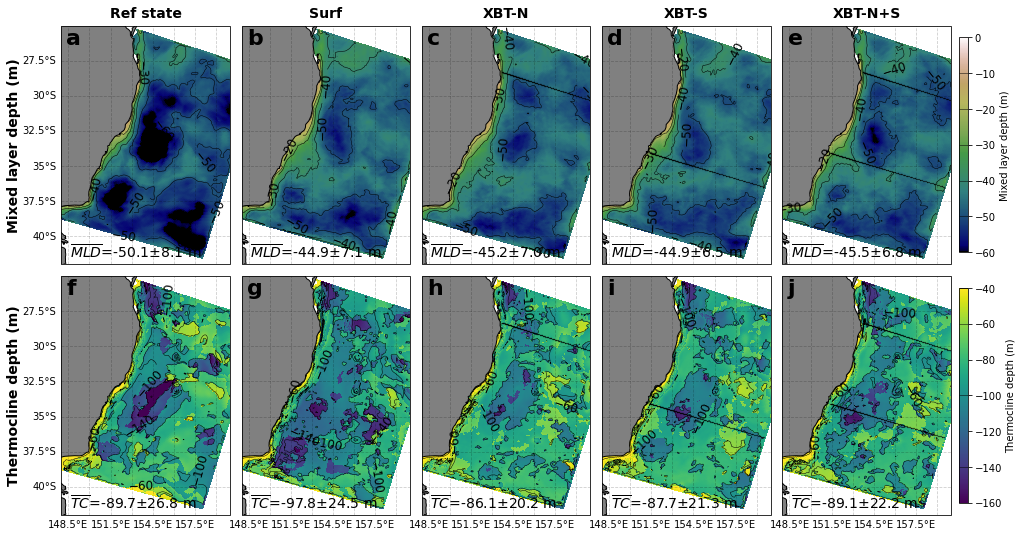

In [51]:


gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,9])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
truth.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-60,vmax=-0)
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthMLD,colors='k',levels=np.arange(-60,0,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{MLD}$='+str(truth.depthMLD.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(truth.depthMLD.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Mixed layer depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.03, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-60,vmax=-0)
co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthMLD,colors='k',levels=np.arange(-60,0,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{MLD}$='+str(SSHSST.depthMLD.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthMLD.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-60,vmax=-0)
co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthMLD,colors='k',levels=np.arange(-60,0,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{MLD}$='+str(SSHSST_XBT_N.depthMLD.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthMLD.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-60,vmax=-0)
co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthMLD,colors='k',levels=np.arange(-60,0,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{MLD}$='+str(SSHSST_XBT_S.depthMLD.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthMLD.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=-60,vmax=-0)
co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthMLD,colors='k',levels=np.arange(-60,0,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{MLD}$='+str(SSHSST_XBT.depthMLD.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthMLD.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('Mixed layer depth (m)')
cbar.add_lines(co)



ax = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
truth.depthTCmaxdTdz.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=-160,vmax=-40)
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthTCmaxdTdz,colors='k',levels=np.arange(-180,0,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{TC}$='+str(truth.depthTCmaxdTdz.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(truth.depthTCmaxdTdz.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Thermocline depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.03, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.depthTCmaxdTdz.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=-160,vmax=-40)
co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthTCmaxdTdz,colors='k',levels=np.arange(-180,0,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{TC}$='+str(SSHSST.depthTCmaxdTdz.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthTCmaxdTdz.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.depthTCmaxdTdz.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=-160,vmax=-40)
co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthTCmaxdTdz,colors='k',levels=np.arange(-180,0,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{TC}$='+str(SSHSST_XBT_N.depthTCmaxdTdz.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthTCmaxdTdz.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)

ax = fig.add_subplot(gs[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.depthTCmaxdTdz.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=-160,vmax=-40)
co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthTCmaxdTdz,colors='k',levels=np.arange(-180,0,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{TC}$='+str(SSHSST_XBT_S.depthTCmaxdTdz.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthTCmaxdTdz.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)

ax = fig.add_subplot(gs[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.depthTCmaxdTdz.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=-160,vmax=-40)
co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthTCmaxdTdz,colors='k',levels=np.arange(-180,0,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{TC}$='+str(SSHSST_XBT.depthTCmaxdTdz.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthTCmaxdTdz.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('Thermocline depth (m)')
cbar.add_lines(co)

# fig.suptitle('Thermocline depth ( z(T(MLD)-0.25(T(MLD)-T(400m)), T(MLD)=SST-0.8)',y=.96, fontsize=14, fontweight='bold')
# fig.suptitle('                  (z(T(MLD)-0.25(T(MLD)-T(400m))))',y=.83, fontsize=14, fontweight='bold',)

In [47]:
truth

<xarray.Dataset>
Dimensions:         (eta_rho: 317, xi_rho: 272, s_rho: 30, ocean_time: 74, s_w: 31)
Coordinates:
    z_rho0          (eta_rho, xi_rho, s_rho) float64 0.0 0.0 ... -4.483 -1.035
  * s_rho           (s_rho) float64 -0.9715 -0.9156 ... -0.0156 -0.004799
  * s_w             (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho         (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho         (eta_rho, xi_rho) float64 -38.5 -38.51 ... -28.15 -28.16
  * ocean_time      (ocean_time) datetime64[ns] 2012-01-01 ... 2012-12-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables: (12/14)
    temp            (ocean_time, s_rho, eta_rho, xi_rho) float64 nan ... 23.66
    dz0             (s_rho, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 3.178 3.178
    dz_w0           (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 1.027 1.027
    dx              (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03
    z_w0            (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.4943 0.4943
    s_w3            (s_w, eta_rho, xi_rho) float64 -1.0 -1.0 -1.0 ... 0.0 0.0
    ...              ...
    temp0           (ocean_time, eta_rho, xi_rho) float64 nan nan ... 23.7 23.66
    tempMLD         (ocean_time, eta_rho, xi_rho) float64 nan nan ... 23.2 23.16
    tempTC          (ocean_time, eta_rho, xi_rho) float64 nan nan ... 20.73
    depthMLD        (eta_rho, xi_rho) float64 nan nan nan ... -35.22 -35.07
    depthTC         (eta_rho, xi_rho) float64 nan nan nan ... -106.6 -106.6
    depthTCmaxdTdz  (eta_rho, xi_rho) float64 nan nan nan ... -63.77 -63.92
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [48]:
# Brief interlude to test the various area averaging functions
weights = truth_bu.dA
weights.name = "weights"


In [49]:
# xarray based area averaging
test = truth.temp.isel(s_rho=-1).weighted(weights).mean(("eta_rho","xi_rho"))
test.mean(("eta_rho","xi_rho"))

ValueError: 'eta_rho' not found in array dimensions ('ocean_time',)

In [ ]:

truth.depthMLD.plot()
plt.show()
truth.z_dtdzmax.plot()
plt.show()
truth.depthTCmaxdTdz.plot()
plt.show()

In [ ]:
STOP